## Imports

In [1]:
# basic packages
import numpy as np
import matplotlib.pyplot as plt

# ML packages
import gensim
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings

# load pre-trained word vector model
import gensim.downloader as api
wv = api.load('glove-wiki-gigaword-50')

from sklearn.decomposition import PCA
from scipy.cluster.vq import kmeans2
from sklearn.cluster import KMeans

## Load Wordbox
2 options:
1. Automatic via web scraper
2. Manually input 16 words

### Web Scraper
Automatically gather 16 words of the day from NYT Games

In [2]:
import time
import os
import zipfile
from selenium import webdriver

# Donwload ChromeDriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait

options = Options()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

In [3]:
# Download and run ChromeDriver
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# go to today's Connections
homepage = "https://www.nytimes.com/games/connections"
driver.execute_script(f"window.open(arguments[0], '_blank');", homepage)
driver.switch_to.window(driver.window_handles[-1]) # open most recently opened window

try:
    button = driver.find_element(By.CSS_SELECTOR, '[data-testid="moment-btn-play"]')
    driver.execute_script("arguments[0].click();", button)
    #print("Play button clicked!")
except Exception as e:
    print(f"Error clicking button: {e}")

inputs = driver.find_elements(By.CSS_SELECTOR, 'label input')
wordbox = [inp.get_attribute('value').lower() for inp in inputs]

print(f"today's words: {wordbox}")

today's words: ['luxe', 'trek', 'bottle', 'wars', 'cope', 'anise', 'sara', 'kelly', 'sage', 'march', 'hunter', 'mace', 'hike', 'pea', 'dill', 'tramp']


In [4]:
# Quit driver once wordbox has been collected
driver.quit()

### Set wordbox manually

In [19]:
# Example from July 6th, 2025
wordbox = ['dre', 'evil', 'pepper', 'seuss', 'ceramics', 'china', 'pottery', 'ware', 'crumb', 'grain', 'morsel', 'shred', 'crypto', 'decaf', 'disney', 'prussian']

## Algorithm A) Follow the Leader

This algorithm starts with finding the highest Word2Vec similarity score between a word pairing from the similarity matrix. Those two words are added to a "solution set".

The next highest similarity scores related to one of the words are added to the set for a total 4 words.
* This is determined by searching for the next highest similarity scores within the same row i.e. finding the most similar words for the "row word" of the original pair.
* This process is repeated for 4 sets of 4 words each.

After a word is added to a set, its corresponding row and column in the similarity matrix is filtered
out using a boolean mask to prevent words being duplicated across sets.
* In the mask, 1 = keep element and 0 = filter out element.
* All diagonal entries are filtered out to start since they represent the similarity score for each word with itself.

In [20]:
'''
Create 16x16 similarity matrix where each row & column represents a word from the wordbox.
    Each element of the matrix contains the Word2Vec similarity score for the words of the row & column.
    Note the matrix will be symmetric with duplicate elements.
'''

n = len(wordbox)

# create similarity matrix
og_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        if i == j:
            continue
        og_matrix[i, j] = wv.similarity(wordbox[i], wordbox[j])

In [21]:
'''
Implement the "Follow the Leader" algorithm.
'''

# stores all sets of words
all_solutions = []

# create boolean mask to filter similarity matrix
diagonal = np.array([1]*len(wordbox))
mask = np.diag(diagonal)
mask[mask == 0] = 2
mask[mask == 1] = 0
mask[mask == 2] = 1

matrices = np.where(mask, og_matrix, np.nan) # filtered form of similarity matrix

# "Follow the Leader" algorithm
for i in range(4):
    all_cols = [] # keeps track of top 3 highest scoring column words for a row word
    curr_solutions = [] # stores current solution set of words

    # find highest similarity score word pair
    row, og_col = np.unravel_index(np.nanargmax(matrices, axis=None), matrices.shape)
    all_cols.append(og_col)
    highest_val = matrices[row, og_col]

    first_word = wordbox[row]
    second_word = wordbox[og_col]

    curr_solutions.extend([first_word, second_word]) # add words to current solution set

    # filter out the found entry from similarity matrix
    mask[row,og_col] = 0
    matrices = np.where(mask, og_matrix, np.nan)

    # find the next highest scoring words for the row word
    for i in range(2):
        col = np.nanargmax(matrices[row], axis=None)
        all_cols.append(col)
        highest_val = matrices[row, col]

        next_word = wordbox[col]
        curr_solutions.append(next_word)
        
        # filter out the found entry from similarity matrix
        mask[row,col] = 0
        matrices = np.where(mask, og_matrix, np.nan)

    # by now, the current solution set has been fully found

    # filter out all words from the current set
    mask[row,:] = np.array([0] * n)
    mask[:,row] = np.array([0] * n)
    for col in all_cols:
        mask[:,col] = np.array([0] * n)
        if col < n:
            mask[col,:] = np.array([0] * n)
    matrices = np.where(mask, og_matrix, np.nan)
        
    all_solutions.append(curr_solutions)

print("Found Solution Sets:")
print("")
for solution_set in all_solutions:
    print(solution_set)

Found Solution Sets:

['ceramics', 'pottery', 'ware', 'grain']
['pepper', 'crumb', 'shred', 'decaf']
['evil', 'disney', 'china', 'seuss']
['dre', 'crypto', 'morsel', 'prussian']


## Algorithm B) Classic Clustering
2 clustering algorithms are used:
1. scikit-learn KMeans
2. sciPy kmeans2

For each algorithm, a cluster size restriction is implemented to ensure that no cluster has more than 5 words, i.e. each cluster has between 1-5 words.

In "2D space clustering," PCA projects the word vectors into 2D for neat cluster visualizations.
In "Custom dimension clustering," you can customize the dimension space for PCA or avoid it entirely.

In [22]:
''' 
Create word vector dataset for clustering.
'''
wordbox_list = []

for word in wordbox:
    wordbox_list.append(wv[word])

### 2D space clustering
Projecting word vectors into 2D allows for easy visualization.

KMeans Results:
['pepper', 'ware', 'crumb', 'shred', 'decaf']
['evil', 'china', 'disney']
['dre', 'seuss', 'morsel', 'crypto']
['ceramics', 'pottery', 'grain', 'prussian']

kmeans2 Results:
['evil', 'china', 'disney']
['ceramics', 'pottery', 'ware', 'grain', 'prussian']
['seuss', 'morsel', 'crypto']
['dre', 'pepper', 'crumb', 'shred', 'decaf']


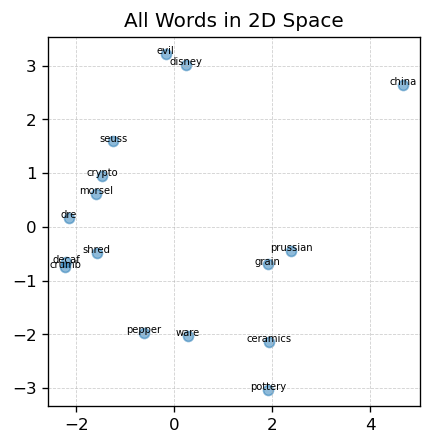

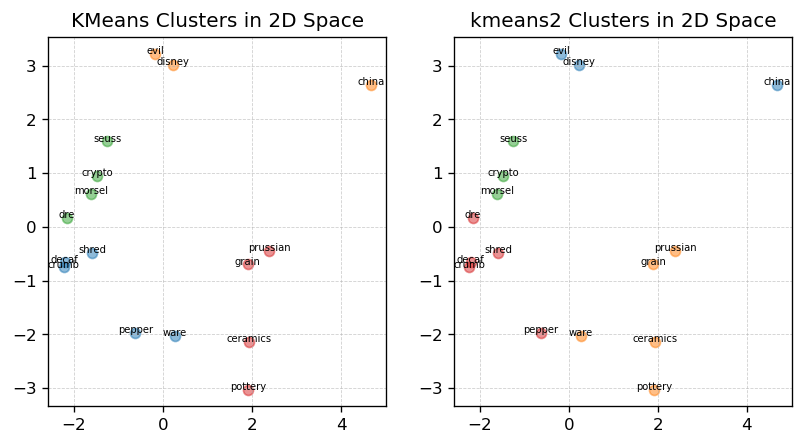

In [23]:
''' 
Prepare dataset for clustering. 
Plot all words and clusters from each implemented algorithm in 2D space.
'''

# set parameters
optimal_k = 4
optimal_dim = 2

obs = np.array(wordbox_list)
obs = PCA(n_components=optimal_dim).fit_transform(obs) # apply PCA to project to 2D

# ------- Plot all words ------- 
fig, ax = plt.subplots(figsize=(4,4), dpi=120)

ax.scatter(obs[:,0], obs[:,1], alpha=0.5)
for i, txt in enumerate(wordbox):
    ax.annotate(txt, (obs[i,0], obs[i,1]), fontsize=6, textcoords="offset points", xytext=(0,0), ha='center')

ax.grid(which='both', alpha=0.6, linestyle='--', linewidth=0.5)
ax.set_title(f"All Words in 2D Space")


''' Run sklearn KMeans Algorithm '''
# repeat clustering until cluster size restriction is met
while True:
    kmeans = KMeans(n_clusters=optimal_k, n_init="auto").fit(obs)
    label = kmeans.labels_
    counts = np.bincount(label)
    if all(count < 6 for count in counts): # cluster size restriction
        break

# ------- Plot KMeans clusters ------- 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4), dpi=120)

for i in range(optimal_k):
    w = obs[label == i]
    ax[0].scatter(w[:, 0], w[:, 1], alpha=0.5, label=f"cluster {i}")

for i, txt in enumerate(wordbox):
    ax[0].annotate(txt, (obs[i,0], obs[i,1]), fontsize=6, textcoords="offset points", xytext=(0,0), ha='center')

ax[0].grid(which='both', alpha=0.6, linestyle='--', linewidth=0.5)
ax[0].set_title(f"KMeans Clusters in 2D Space")

# ------- Print KMeans cluster groups in text -------
group_dict = {i: [] for i in range(optimal_k)}

for i in range(len(label)):
    l = label[i]
    word = wordbox[i]
    group_dict[l].append(word)

print("KMeans Results:")
for key, value in group_dict.items():
    print(f"{value}")


''' Run SciPy kmeans2 Algorithm '''
# repeat clustering until cluster size restriction is met
while True:
    centroid, label = kmeans2(data=obs, k=optimal_k, iter=300, minit="++")
    counts = np.bincount(label)
    if all(count < 6 for count in counts):
        break

# ------- Plot kmeans2 clusters ------- 
for i in range(optimal_k):
    w = obs[label == i]
    ax[1].scatter(w[:, 0], w[:, 1], alpha=0.5, label=f"cluster {i}")

for i, txt in enumerate(wordbox):
    ax[1].annotate(txt, (obs[i,0], obs[i,1]), fontsize=6, textcoords="offset points", xytext=(0,0), ha='center')

ax[1].grid(which='both', alpha=0.6, linestyle='--', linewidth=0.5)
ax[1].set_title(f"kmeans2 Clusters in 2D Space")

# ------- Print kmeans2 cluster groups in text -------
group_dict = {i: [] for i in range(4)}

for i in range(len(label)):
    l = label[i]
    word = wordbox[i]
    group_dict[l].append(word)

print("")
print("kmeans2 Results:")
for key, value in group_dict.items():
    print(f"{value}")

### Custom dimension clustering
Input desired dimension space via PCA in the following cell. Both clustering algorithms are run to produce 

The maximum PCA dimension space is 16.
To avoid PCA entirely, input "0" for the dimension.

In [24]:
''' User Input '''
dimension = 0

In [25]:
''' Run clustering algorithms. '''
optimal_k = 4

# ------- Apply PCA ------- 
obs = np.array(wordbox_list)
   
if dimension != 0:
    print(f"Dimension: {dimension}")
    obs = PCA(n_components=dimension).fit_transform(obs)
else:
    print(f"PCA Not Applied")

# ------- Run KMeans -------     
print("")
print("KMeans Results:")
while True:
    kmeans = KMeans(n_clusters=optimal_k, n_init="auto").fit(obs)
    label = kmeans.labels_
    counts = np.bincount(label)
    if all(count < 6 for count in counts):
        break

# ------- Print KMeans cluster groups in text -------
group_dict = {i: [] for i in range(optimal_k)}

for i in range(len(label)):
    l = label[i]
    word = wordbox[i]
    group_dict[l].append(word)

for key, value in group_dict.items():
    print(f"{value}")


# ------- Run kmeans2 ------- 
print("")
print("kmeans2 Results:")
while True:
    centroid, label = kmeans2(data=obs, k=optimal_k, iter=300, minit="++")
    counts = np.bincount(label)
    if all(count < 6 for count in counts):
        break

# ------- Print KMeans cluster groups in text -------
group_dict = {i: [] for i in range(4)}

for i in range(len(label)):
    l = label[i]
    word = wordbox[i]
    group_dict[l].append(word)

for key, value in group_dict.items():
    print(f"{value}")

PCA Not Applied

KMeans Results:
['seuss', 'morsel', 'shred', 'crypto', 'decaf']
['dre', 'pepper', 'crumb']
['ceramics', 'pottery', 'ware', 'grain', 'prussian']
['evil', 'china', 'disney']

kmeans2 Results:
['pepper', 'ware', 'crumb', 'grain', 'shred']
['dre', 'morsel', 'crypto', 'decaf']
['ceramics', 'china', 'pottery', 'prussian']
['evil', 'seuss', 'disney']
